<a href="https://colab.research.google.com/github/ch-manasa/AI-and-ML/blob/main/Easy_Visa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Advanced Machine Learning: Easy Visa - Solution Notebook**

# Problem Definition

The objective is to build a classification model for EasyVisa to predict the visa approval status - Certified or Denied based on applicant profile and employer data. This will help OFLC streamline the review process by shortlisting high-probability applications.

## Context

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective

The Office of Foreign Labor Certification (OFLC) processes a very large number of visa applications every year. Manual review of applications is time-consuming and inefficient.

Build a classification model that can help:
  * Shortlist applications with a high probability of visa certification
  * Identify key drivers influencing visa approval or denial
  * Support faster, data-driven decision making

## Data Description

* The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application

* continent: Information of continent the employee

* education_of_employee: Information of education of the employee

* has_job_experience: Does the employee has any job experience? Y= Yes; N = No

* requires_job_training: Does the employee require any job training? Y = Yes; N = No

* no_of_employees: Number of employees in the employer's company

* yr_of_estab: Year in which the employer's company was established

* region_of_employment: Information of foreign worker's intended region of employment in the US.

* prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.

* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.

* full_time_position: Is the position of work full-time? Y = Full-Time Position; N = Part-Time Position

* case_status: Flag indicating if the Visa was certified or denied

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Background and content

In [ ]:
df_easyvisa = pd.read_csv('/content/drive/MyDrive/AI&ML/ML/EasyVisa.csv')
# Data Overview
df_easyvisa.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [ ]:
df_easyvisa.shape

(25480, 12)

The dataset has 25,480 rows and 12 columns

In [ ]:
# Need to check the data type of the columns
df_easyvisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


Observations:

* The dataset contains 25480 visa applications.

* There are no null values (non-null count matches total rows), so explicit missing value imputation is not required.

* Dataset contains a mix of Objects, Float and integer data types.

* case_id is a unique identifier column and will be dropping it as it will not provide any insights.

* Target variable is case_status.

In [ ]:
df_easy_visa = df_easyvisa.drop('case_id', axis=1)

In [ ]:
df_easy_visa.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [ ]:
df_easy_visa.isnull().sum()

,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0
full_time_position,0


Observations:

* Validating the above, wheter all are non null. We can confirm there are no missing values in the data.

In [ ]:
df_easy_visa.duplicated().sum()

np.int64(0)

Observations

* There are no duplicate observations in the data.

## Statistical Summary

In [ ]:
df_easy_visa.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


Observations:
1) Number of employees: The median company has ~2,109 employees, maximum has ~6L employees. We can see that distribution is hihgly right skewed.

2) Company age: companies average year established is 1979.

3) prevailing wage:
prevailing_wage has a high standard deviation, indicating potential outliers.

mean is 74k, median is 70k, since mean > median, we can see that it is slightly right skewed.

Min salary is \$2, doesnt seem realistic - this could be, could be seeing incorrect data or mostly hourly wage as we see unit of wage has hourly, weekly as well.

Most workers seem to earn \$30k-\$100k.





###Treating negative values

In [ ]:
# Replace invalid negative values with NaN
df_easy_visa.loc[df_easy_visa['no_of_employees'] < 0, 'no_of_employees'] = np.nan

# Impute using median
df_easy_visa['no_of_employees'] = df_easy_visa['no_of_employees'].fillna(df_easy_visa['no_of_employees'].median())

In [ ]:
df_easy_visa.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5669.801531,22877.371642,12.0000,1028.00,2112.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


In [ ]:
print(df_easy_visa['no_of_employees'].describe())
print('Any negatives now?', (df_easy_visa['no_of_employees'] < 0).sum())

count     25480.000000
mean       5669.801531
std       22877.371642
min          12.000000
25%        1028.000000
50%        2112.000000
75%        3504.000000
max      602069.000000
Name: no_of_employees, dtype: float64
Any negatives now? 0


Handled negative values for number of employees.
Treated with median number of employees.

## **Exploratory Data Analysis**

## Univariate Analysis

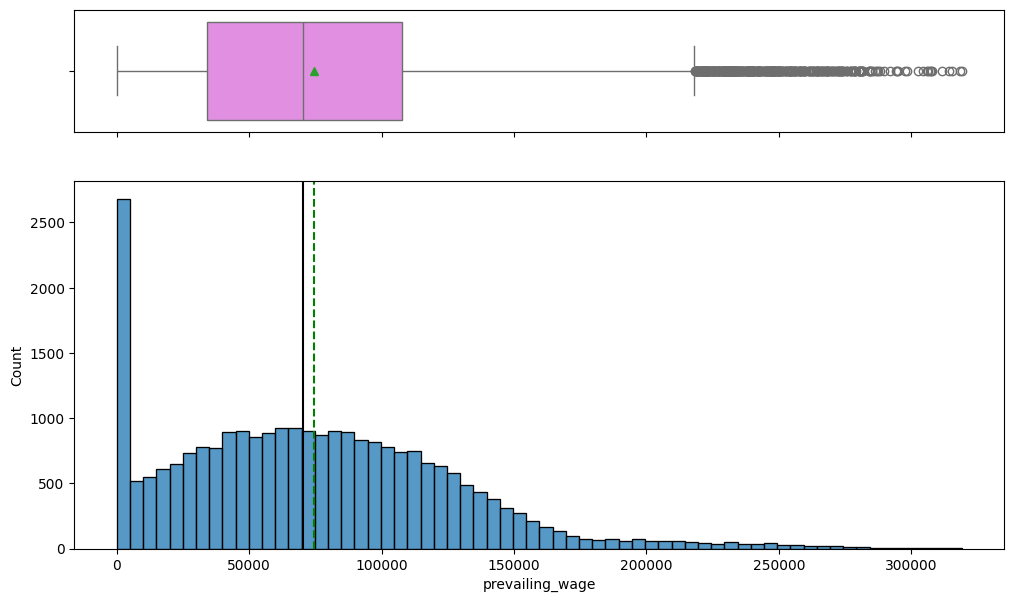

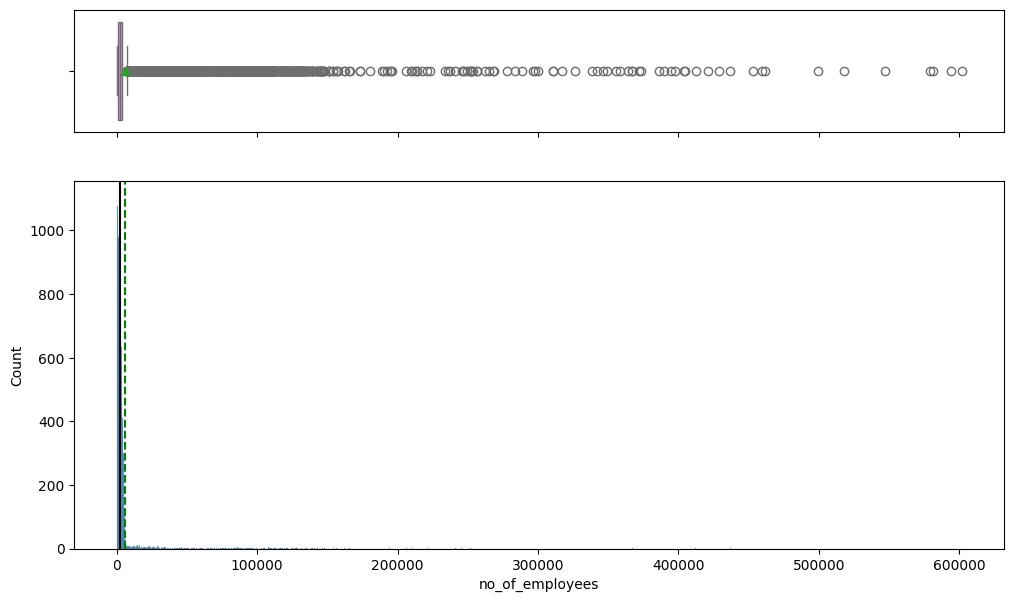

In [ ]:
# Function to plot histograms and boxplots for numerical columns
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")
    sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter") if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

# Plot Prevailing Wage
histogram_boxplot(df_easy_visa, 'prevailing_wage')
plt.show()

# Plot No of Employees
histogram_boxplot(df_easy_visa, 'no_of_employees')
plt.show()

In [ ]:
# Function for labeled barplots (Categorical)
def labeled_barplot(data, feature, perc=False, n=None):
    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data, x=feature,hue=feature, palette="Paired", order=data[feature].value_counts().index[:n].sort_values())
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total)
        else:
            label = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(label, (x, y), ha="center", va="bottom", size=12)
    plt.show()

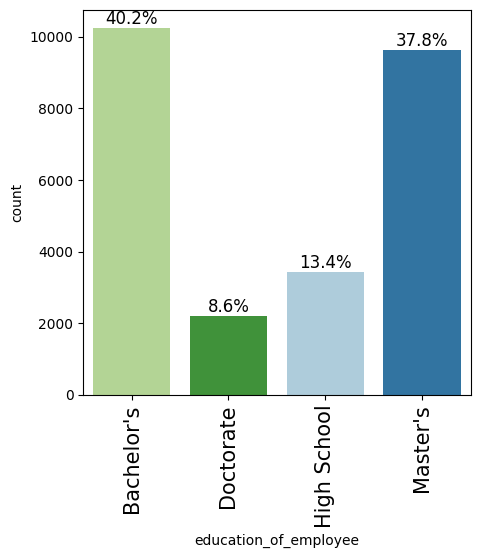

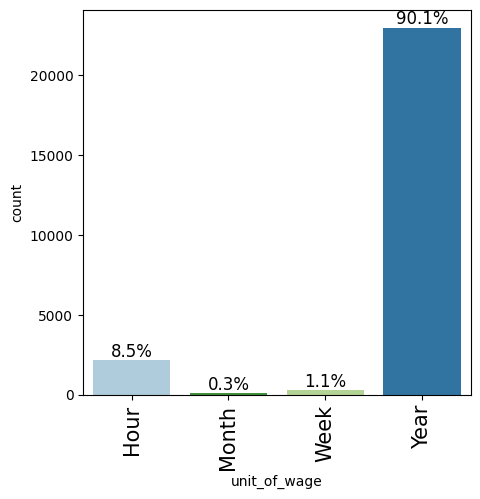

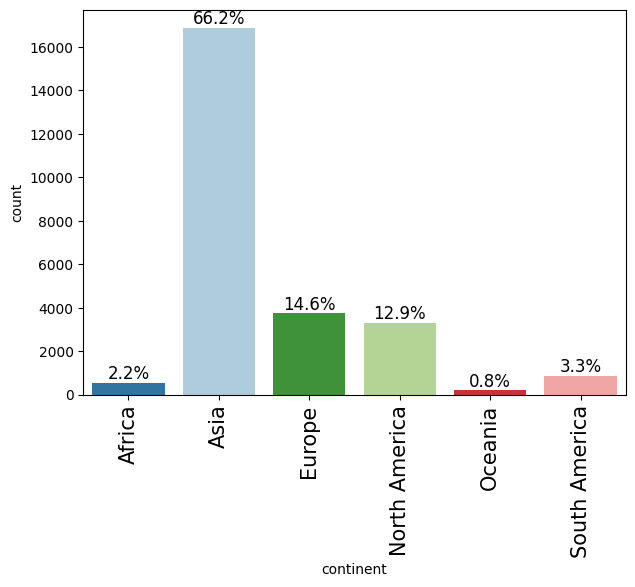

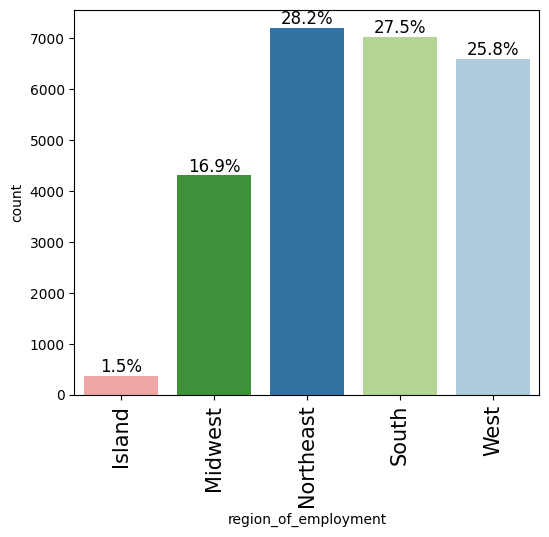

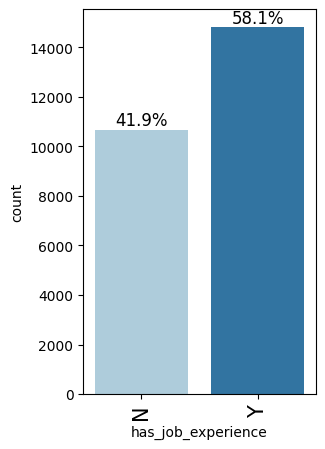

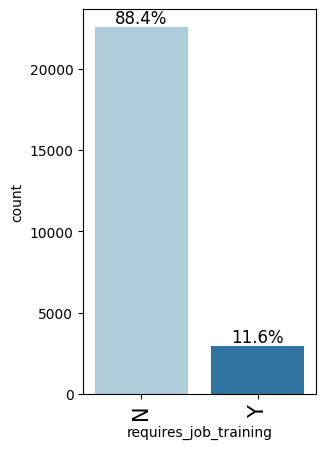

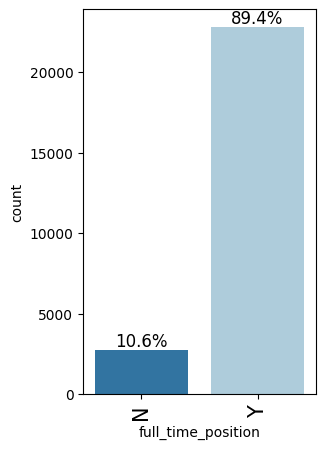

In [ ]:
# Education
labeled_barplot(df_easy_visa, 'education_of_employee', perc=True)

# Unit of wage
labeled_barplot(df_easy_visa, 'unit_of_wage', perc=True)

# Continent
labeled_barplot(df_easy_visa, "continent", perc=True)

# Region of Employment
labeled_barplot(df_easy_visa, "region_of_employment", perc=True)

# Has Job Experience
labeled_barplot(df_easy_visa, "has_job_experience", perc=True)

# Requires Job Training
labeled_barplot(df_easy_visa, "requires_job_training", perc=True)

# Full Time Position
labeled_barplot(df_easy_visa, "full_time_position", perc=True)

Observations from Univariate Analysis:

1) Case Status: About 66.8% of visas are Certified and 33.2% Denied. The dataset is imbalanced. A model that predicts certified will always have ~67% accuracy so accuracy alone will not be sufficient need to use metrics like F1, Recall, ROC-AUC.

2) Wage: The prevailing_wage is strong right-skewed with many outliers on the high end. Most wages clustered around $50k-$80k. Some extreme outliers going beyond $200k

3) Education: Most applicants hold atleast a Bachelor's Degree. we see that very few have low education implying the dataset is already filtered towards skilled workers.

4) Employees: Strong right skew, Most companies have fewer than 20,000 employees, but there are massive outlier corporations.

5) unit of wage: Most visas are full time salaried postions i.e yearly based.

6) Region of employment: Visa applications are heavily concentrated in Northeast, South, and West (≈ 81%). Island is extremely rare → will be noisy in modeling. Region has class imbalance and may impact model.

7) Continent: Two third of the applicants are from Asia. Africa, Oceania, South America are minority classes. Chances are that the model will be dominated by Asia applicants. Class imabalance must be addressed.

8) Has job experience: Most applicants do have prior experience.But a large minority (42%) do not, so this feature has high variability.

9) Requires Job Training: Very few jobs require training.

10) Full time position: Most visas are for full-time roles, Part-time roles are rare.

#### Treating outlieres

we cant afford to loose important data of high paying companies, as there might be companies paying high wages and applying for visas and the model needs to learn them.

In [ ]:
print("Original Skewness: Prevailing Wage:", df_easy_visa["prevailing_wage"].skew())
print("Original Skewness: No of Employees:", df_easy_visa["no_of_employees"].skew())

Original Skewness: Prevailing Wage: 0.7557760603032042
Original Skewness: No of Employees: 12.265809580554345


In [ ]:
# Function to treat outliers
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    # Cap the values to lower and upper whiskers.
    df[col] = np.clip(df[col], lower_whisker, upper_whisker)
    return df

# Apply the treatment to the specific columns with outliers

# df_easy_visa = treat_outliers(df_easy_visa, 'prevailing_wage')
# df_easy_visa = treat_outliers(df_easy_visa, 'no_of_employees')

* The variables prevailing_wage and no_of_employees exhibited extremely wide ranges and strong right skewness, which is expected in real-world economic and organizational data. It had a very large range with meaningful extreme values. Since wage data is naturally long-tailed and multiplicative in nature.

* Instead of removing or capping outliers using IQR, a log1p transformation is applied. This approach:

  * Compresses large values while preserving relative ordering

  * Retains economically meaningful extreme cases (e.g., large employers, high-wage roles)

  * Improves model stability without information loss


### Performing Log Transformation to reduce skewness

Note: No IQR-based capping was applied, as extreme values reflect genuine labor market and firm size differences rather than anomalies.

In [ ]:
df_easy_visa['no_of_employees'] = np.log1p(df_easy_visa['no_of_employees'])
df_easy_visa["prevailing_wage"] = np.log1p(df_easy_visa["prevailing_wage"])

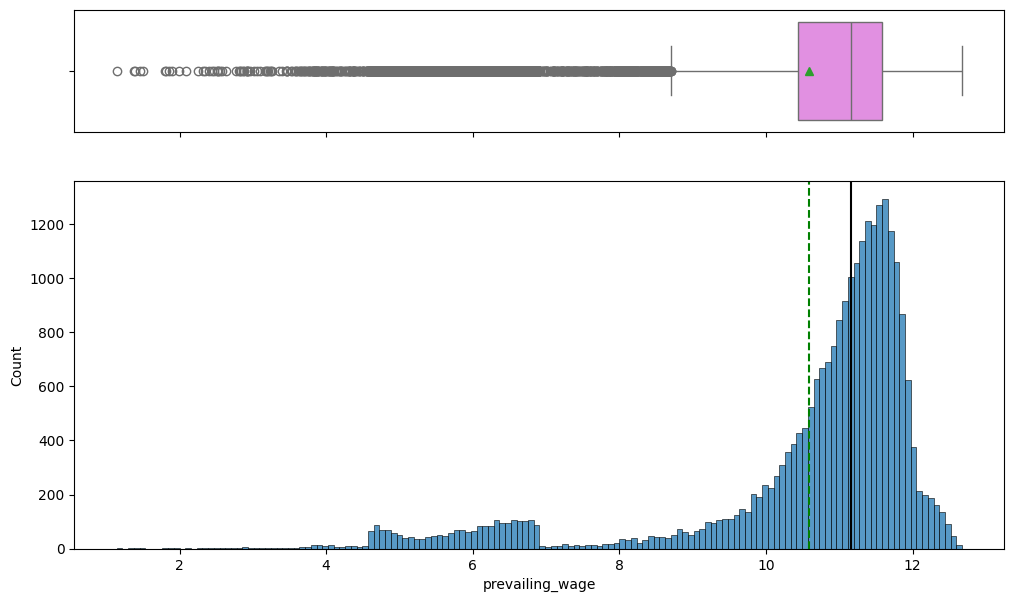

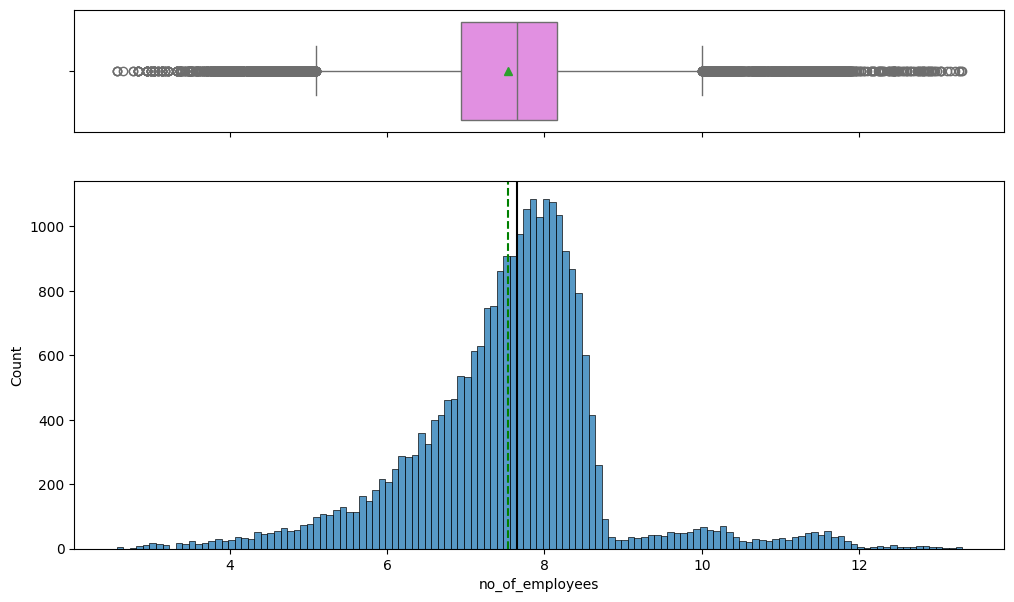

In [ ]:
#visualize after log
histogram_boxplot(df_easy_visa, "prevailing_wage")

histogram_boxplot(df_easy_visa, "no_of_employees")

Observations + Rationale

* I have tested individually with both Methods for both columns :

    1) IQR Capping - prevailing wage is reducing to ~0.54, no of emplyees was reducing to ~0.95.

    2) Log transformations - prevailing wage is reduced to ~ -2.2, no of employees to ~0.15. Log transformation is too aggressive for mild skewness of previaling wage and it overcorrected. For no of employees the skew dropped from massive (12.2) to near-zero (0.15). The Log transform worked great here because the range was huge.


In [ ]:
print("After treating Skewness: IQR - Prevailing Wage :", df_easy_visa["prevailing_wage"].skew())
print("After treating Skewness: log transform - No of Employees:", df_easy_visa["no_of_employees"].skew())

After treating Skewness: IQR - Prevailing Wage : -2.128367732760211
After treating Skewness: log transform - No of Employees: 0.15604455764895483


Observation:

* Post-transformation, the distributions showed reduced skewness while still containing extreme values, as the primary objective is scale compression rather than perfect symmetry These remaining “outliers” are valid observations, not noise, and tree-based models such as Random Forest and XGBoost are robust to them.

* The objective of log transformation is to reduce scale and leverage of extreme wage values, not to achieve perfect symmetry. Negative skew after log transformation is acceptable as the transformation preserves ordering and economic meaning, unlike IQR capping which removes valid high-end wage information.

## Bivariate Analysis

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


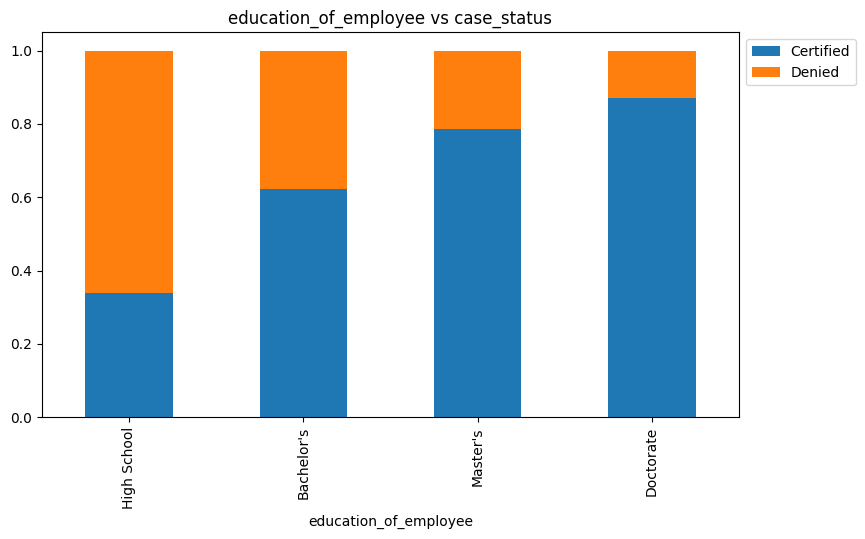

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


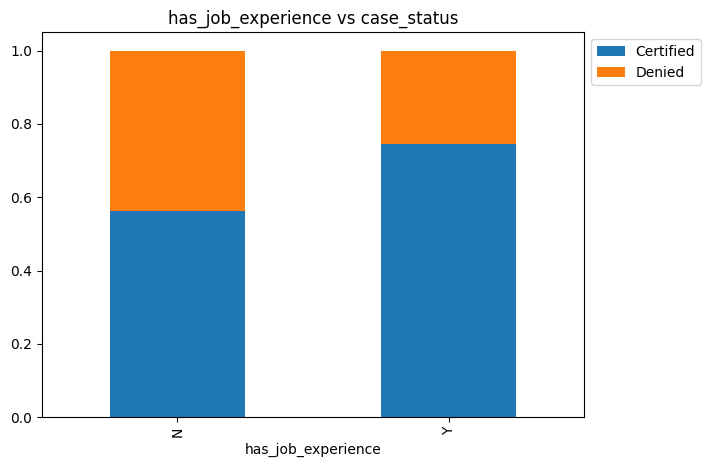

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


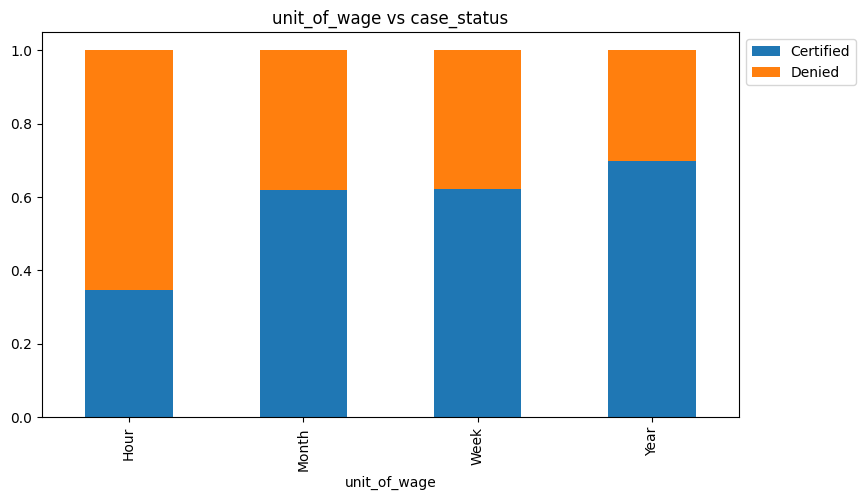

case_status           Certified  Denied    All
region_of_employment                          
All                       17018    8462  25480
Northeast                  4526    2669   7195
West                       4100    2486   6586
South                      4913    2104   7017
Midwest                    3253    1054   4307
Island                      226     149    375
------------------------------------------------------------------------------------------------------------------------


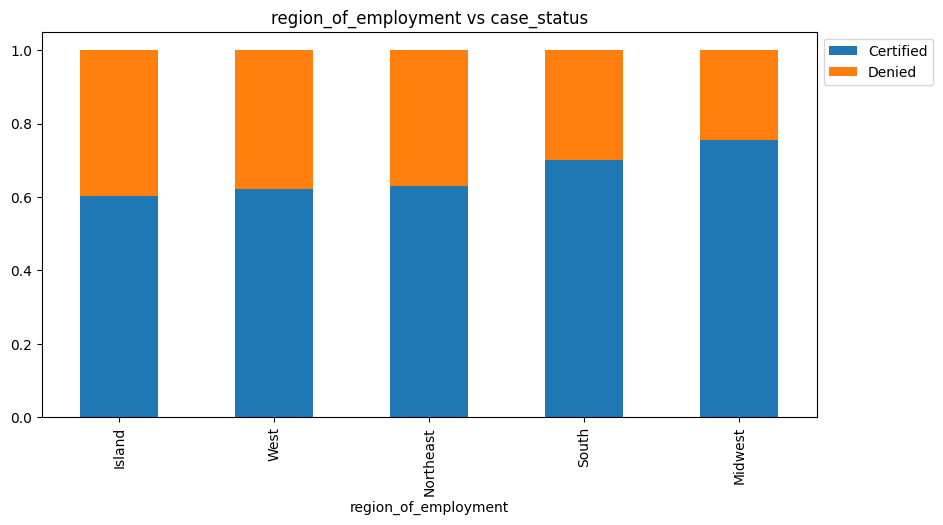

In [ ]:
# Function to plot stacked bar charts (Categorical vs Target)
def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    print(tab1)
    print("-" * 120)
    # Visualizing
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(by=sorter, ascending=False)
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="lower left", frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title(f"{predictor} vs {target}")
    plt.show()

# 1. Education vs Case Status
stacked_barplot(df_easy_visa, 'education_of_employee', 'case_status')

# 2. Job Experience vs Case Status
stacked_barplot(df_easy_visa, 'has_job_experience', 'case_status')

# 3. Unit of Wage vs Case Status (Critical per FAQ)
stacked_barplot(df_easy_visa, 'unit_of_wage', 'case_status')

# 4. Region vs Case Status
stacked_barplot(df_easy_visa, 'region_of_employment', 'case_status')


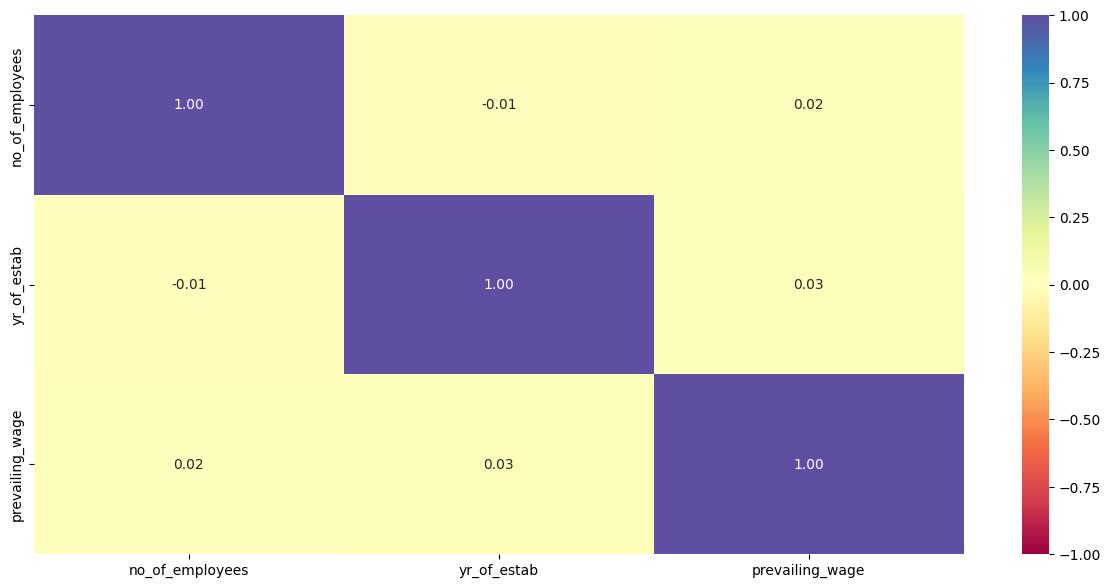

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_easy_visa.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

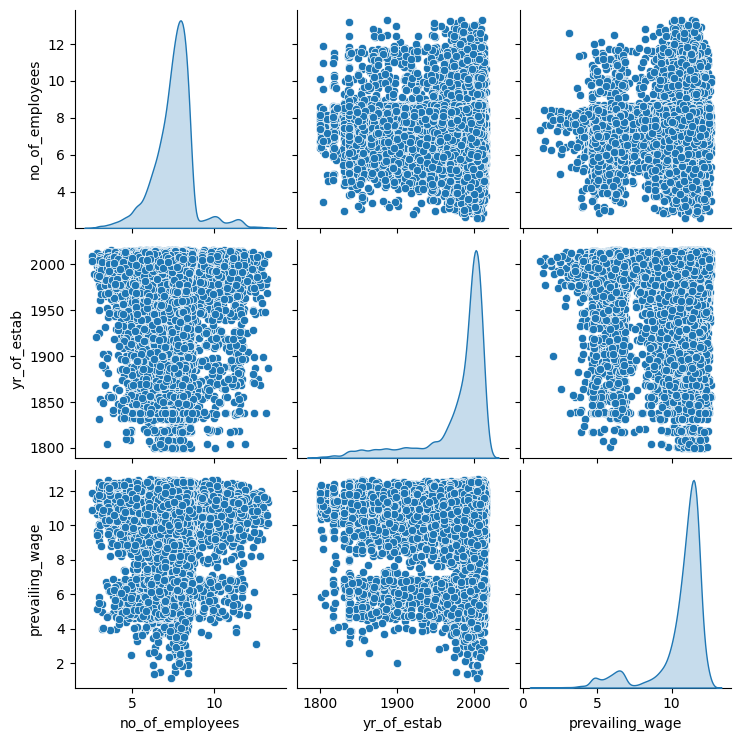

In [ ]:
sns.pairplot(data=df_easy_visa.select_dtypes(include=['int64','float64']), diag_kind="kde")
plt.show()

Observations:

1) Applicants with masters and doctorate degrees have higher chances of visa approval compared to high school graduates
2) Applicants with a job experience have a higher rate of visa approval.(This aligns with immigration policies, as hourly wages are generally associated with contract/temporary/ or low-skill roles, which face stricter scrutiny.)
3) Applications with hourly unit of wage have a higher denial rate compared to that of yearly.
4) Region of employment doesnt seem to impact the outcome of the visa status.
Safe to say higher education, job experience and to have a yearly unit of wage can give u a more chances of successful visa.

#### Additional Feature Engineering

Some hypothesis:

* Instead of using year of establishment,created company age because visa officers are more likely to trust established firms over newer ones.

In [ ]:
df_easyvisa_fe = df_easy_visa
df_easyvisa_fe["company_age"] = 2016 - df_easyvisa_fe["yr_of_estab"]
df_easyvisa_fe.drop("yr_of_estab", axis=1, inplace=True)

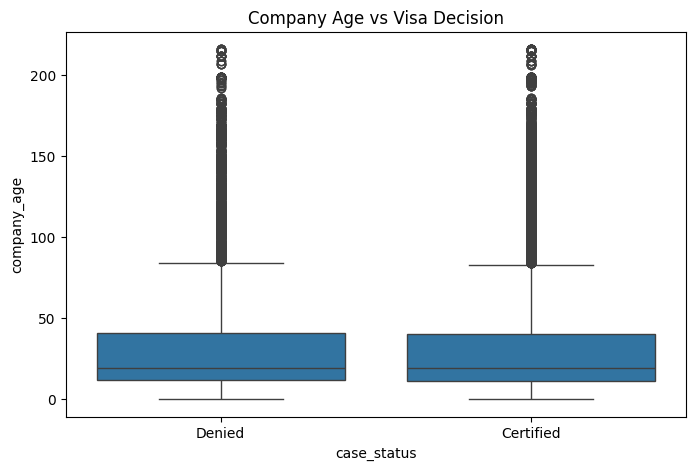

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="case_status", y="company_age", data=df_easyvisa_fe)
plt.title("Company Age vs Visa Decision")
plt.show()

In [ ]:
df_easyvisa_fe.groupby("case_status")["company_age"].describe()

,count,mean,std,min,25%,50%,75%,max
case_status,,,,,,,,
Certified,17018.0,36.333235,42.278601,0.0,11.0,19.0,40.0,216.0
Denied,8462.0,37.106594,42.541819,0.0,12.0,19.0,41.0,216.0


Observation:

Company age shows almost identical distributions for certified and denied cases. The median, quartiles, and spread are nearly the same across both groups, indicating that employer age alone does not significantly influence visa approval decisions.

Final thoughts on noise in data:

* Although yr_of_estab showed weak correlation with case status, i transformed into company_age to better reflect business meaning. However, bivariate analysis shows that company age has nearly identical distributions for certified and denied cases, indicating limited predictive power.

So **my hypothesis can be rejected**.

### Statistical Significance Report

In [ ]:
def statistical_significance_report(df, target_col):
    print("------------------------------------------------------")
    print("      STATISTICAL SIGNIFICANCE REPORT (EDA)")
    print("------------------------------------------------------")

    # 1. CATEGORICAL VS TARGET (Chi-Square Test)
    print("\nCategorical Features vs Target (Chi-Square)")
    print(f"Null Hypothesis (H0): Feature has NO relationship with {target_col}")
    print(f"Alt Hypothesis (H1): Feature related to {target_col}")
    print("-" * 65)
    print(f"{'Feature':<30} | {'P-Value':<12} | {'Result'}")
    print("-" * 65)

    cat_cols = df.select_dtypes(include='object').columns.tolist()
    if target_col in cat_cols: cat_cols.remove(target_col)

    for col in cat_cols:
        # Create a contingency table
        crosstab = pd.crosstab(df[col], df[target_col])
        stat, p, dof, expected = chi2_contingency(crosstab)

        sig = "Significant" if p < 0.05 else "Not Significant"
        print(f"{col:<30} | {p:.5f}      | {sig}")

    # 2. NUMERIC VS TARGET (ANOVA / T-Test)
    print("\nNumeric Features vs Target (ANOVA)")
    print(f"Null Hypothesis (H0): Means are SAME across {target_col} groups")
    print("-" * 65)
    print(f"{'Feature':<30} | {'P-Value':<12} | {'Result'}")
    print("-" * 65)

    num_cols = df.select_dtypes(include='number').columns.tolist()

    groups = df[target_col].unique()

    for col in num_cols:
        group_data = [df[df[target_col] == g][col] for g in groups]
        stat, p = f_oneway(*group_data)

        sig = "Significant" if p < 0.05 else "Not Significant"
        print(f"{col:<30} | {p:.5f}      | {sig}")

# Run the function
statistical_significance_report(df_easy_visa, 'case_status')

------------------------------------------------------
      STATISTICAL SIGNIFICANCE REPORT (EDA)
------------------------------------------------------

Categorical Features vs Target (Chi-Square)
Null Hypothesis (H0): Feature has NO relationship with case_status
Alt Hypothesis (H1): Feature related to case_status
-----------------------------------------------------------------
Feature                        | P-Value      | Result
-----------------------------------------------------------------
continent                      | 0.00000      | Significant
education_of_employee          | 0.00000      | Significant
has_job_experience             | 0.00000      | Significant
requires_job_training          | 0.18556      | Not Significant
region_of_employment           | 0.00000      | Significant
unit_of_wage                   | 0.00000      | Significant
full_time_position             | 0.04470      | Significant

Numeric Features vs Target (ANOVA)
Null Hypothesis (H0): Means are SAM

Feature Engineering Decision (Prevailing Wage):

  * The prevailing_wage variable was not normalized to a yearly scale to avoid introducing assumptions about working hours and contract structure - instead, unit_of_wage was retained as a categorical feature, allowing tree-based models to learn wage-unit interactions directly without bias.

Rationale:

  * Converting hourly or weekly wages requires making assumptions about working hours (ex: assuming a 40-hour work week), which introduces potential bias and inaccuracies since contract types vary.

  * The Tree-based models are capable of learning the interaction between the wage amount and the wage unit (ex: distinguishing that $60/hour is a high wage, whereas $60/year is invalid) without explicit normalization.

## Data Preprocesing

In [ ]:
# Encoding target variable
df_easy_visa['case_status'] = df_easy_visa['case_status'].apply(lambda x: 1 if x == 'Certified' else 0)

# Separate features (X) and target (y)
X = df_easy_visa.drop('case_status', axis=1)
y = df_easy_visa['case_status']

# One hot encoding for features only
X = pd.get_dummies(X, drop_first=True)

#Split train to test dataset with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify = y)

print("Training dataset size:", X_train.shape)
print("\nTesting dataset size:", X_test.shape)

# Check if the split stratification worked
print("\nRatio of Certified cases in Train Set:")
print(y_train.value_counts(normalize=True))
print("\nRatio of Certified cases in Test Set:")
print(y_test.value_counts(normalize=True))

Training dataset size: (17836, 21)

Testing dataset size: (7644, 21)

Ratio of Certified cases in Train Set:
case_status
1    0.667919
0    0.332081
Name: proportion, dtype: float64

Ratio of Certified cases in Test Set:
case_status
1    0.667844
0    0.332156
Name: proportion, dtype: float64


Rationale:

Choosing 70:30 split + cross validation as I am planning to use gridsearch and randomizedsearchcv, instead of 3 way split of train - validation - test  which is more manual.

Mainly the toal number of rows is around ~25k, id we split 3-way we have ~15k records for training, but if we split 2 way we will have ~17k records

Observations:

Dimensionality: The number of columns increased from 12 to 21 due to categorical columns expanding to indivdual binary columns.

Data Integrity: The stratification was successful, the ratio of certified cases is consistent across both training and testing datasets, to ensure fail results.


## Model Building


### Initiate model building

* A total of 6 classification models will be evaluated, covering tree-based, bagging, and boosting techniques

In [ ]:
models = []
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(eval_metric='logloss', random_state=1)))

results_kfold = []
results_skfold = []
names = []

In [ ]:
print("\n----- KFold-----" "Cross-Validation Performance (F1 Score):" "\n")

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # We use 'f1' score as our primary metric
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='f1', cv=kfold)

    results_kfold.append(cv_result)
    print("{}: Mean F1 = {:.4f} (Std = {:.4f})".format(name, cv_result.mean(), cv_result.std()))


----- KFold-----Cross-Validation Performance (F1 Score):

Decision Tree: Mean F1 = 0.7416 (Std = 0.0047)
Bagging: Mean F1 = 0.7744 (Std = 0.0015)
Random Forest: Mean F1 = 0.8014 (Std = 0.0041)
AdaBoost: Mean F1 = 0.8192 (Std = 0.0047)
Gradient Boosting: Mean F1 = 0.8250 (Std = 0.0051)
XGBoost: Mean F1 = 0.8100 (Std = 0.0035)


In [ ]:
print("\n----Straified KFold----" "Cross-Validation Performance (F1 Score):" "\n")

for name, model in models:
    # StratifiedKFold ensures our class balance (66/33) is kept in every fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # We use 'f1' score as our primary metric
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='f1', cv=skfold)

    results_skfold.append(cv_result)
    names.append(name)
    print("{}: Mean F1 = {:.4f} (Std = {:.4f})".format(name, cv_result.mean(), cv_result.std()))


----Straified KFold----Cross-Validation Performance (F1 Score):

Decision Tree: Mean F1 = 0.7441 (Std = 0.0032)
Bagging: Mean F1 = 0.7766 (Std = 0.0019)
Random Forest: Mean F1 = 0.8039 (Std = 0.0026)
AdaBoost: Mean F1 = 0.8208 (Std = 0.0034)
Gradient Boosting: Mean F1 = 0.8225 (Std = 0.0021)
XGBoost: Mean F1 = 0.8080 (Std = 0.0017)


Rationale:

Choosing StartifiedKFold:
1) handles Class imbalance: as ~67% certified, ~33% Denied.
KFold will randomly cut the data and chances of one fold getting one type that the other makes the evaluation inconsistent.
2) Stability: notice that the standard deviation is kind off lower / alomost cut in half for some models when stratifiedKFold is used. Lower std indicates model is more stable.


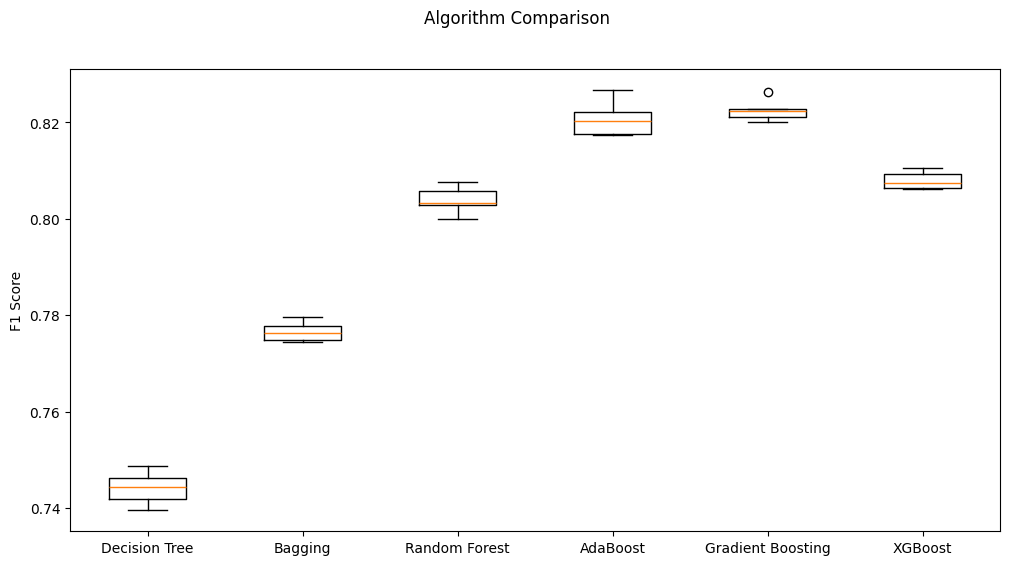

In [ ]:
# Plotting Boxplots
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Algorithm Comparison ")
ax = fig.add_subplot(111)
plt.boxplot(results_skfold)
ax.set_xticklabels(names)
plt.ylabel("F1 Score")
plt.show()

Observations:

1) Top performer: Gradient boosting with 82.46%, followed by Adaboost with 81.93% followed by XGboost with 80.77%
2) Ensemble power: All the ensemble methods has outperformed the decision tree,baggind, random forest showing that combined models can reduce error.
3) Stability: low standard deviations (mostly < 0.004) indicating that the models are robust and not overfitting to specific chunks of data.

### Model Building - Oversampled Data

Rationale: The dataset is imbalanced (33% Denied). We use SMOTE to create synthetic 'Denied' cases so the model sees a 50/50 split.

Before SMOTE: 
counts of label '1': 11913

counts of label '0': 5923 

After SMOTE: 
counts of label '1': 11913

counts of label '0': 11913 


Cross-Validation Performance (Oversampled Data):

Decision Tree: Mean F1 = 0.6948 (Std = 0.0076)
Bagging: Mean F1 = 0.7157 (Std = 0.0103)
Random Forest: Mean F1 = 0.7698 (Std = 0.0082)
AdaBoost: Mean F1 = 0.7338 (Std = 0.0091)
Gradient Boosting: Mean F1 = 0.7530 (Std = 0.0088)
XGBoost: Mean F1 = 0.7509 (Std = 0.0052)


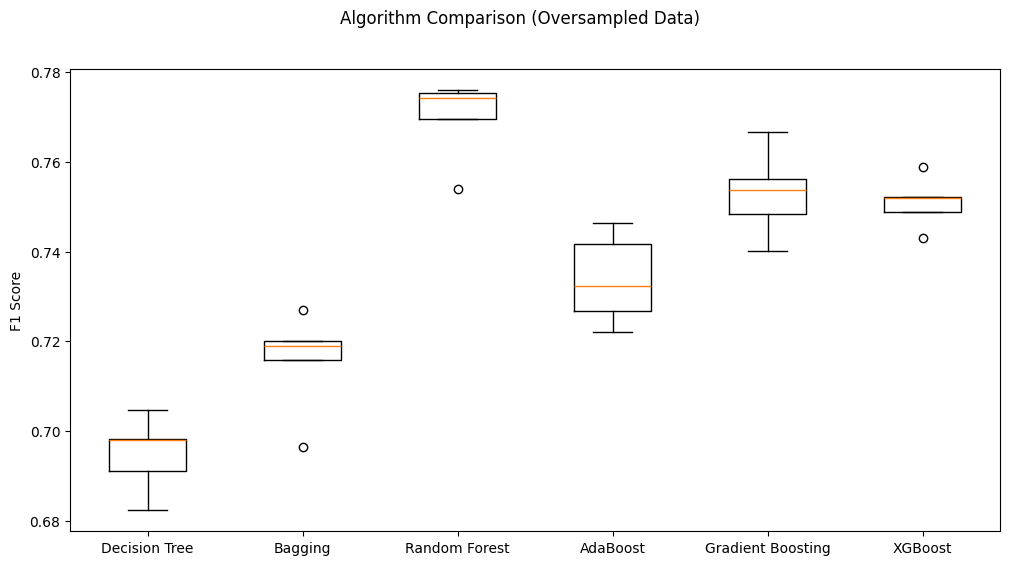

In [ ]:
print("Before SMOTE: \ncounts of label '1': {}".format(sum(y_train == 1)))
print("\ncounts of label '0': {} \n".format(sum(y_train == 0)))

# Apply SMOTE to Training Data ONLY
sm = SMOTE(random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After SMOTE: \ncounts of label '1': {}".format(sum(y_train_over == 1)))
print("\ncounts of label '0': {} \n".format(sum(y_train_over == 0)))

# Re-run the model loop on oversampled data
results_over = []
names_over = []

print("\n" "Cross-Validation Performance (Oversampled Data):" "\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # fit on X_train_over and y_train_over
    cv_result = cross_val_score(estimator=model, X=X_train_over, y=y_train_over, scoring='f1', cv=kfold)
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: Mean F1 = {:.4f} (Std = {:.4f})".format(name, cv_result.mean(), cv_result.std()))

# Plot Comparison
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Algorithm Comparison (Oversampled Data)")
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over)
plt.ylabel("F1 Score")
plt.show()

### Model Building - Undersampled Data

Rationale: We randomly delete 'Certified' cases until they match the number of 'Denied' cases. This is faster but we will lose data.

Before RandomUnderSampler: 
counts of label '1': 11913
counts of label '0': 5923 

After RandomUnderSampler: 
counts of label '1': 5923
counts of label '0': 5923 


Cross-Validation Performance (Undersampled Data):

Decision Tree: Mean F1 = 0.6219 (Std = 0.0107)
Bagging: Mean F1 = 0.6421 (Std = 0.0105)
Random Forest: Mean F1 = 0.6869 (Std = 0.0044)
AdaBoost: Mean F1 = 0.6959 (Std = 0.0108)
Gradient Boosting: Mean F1 = 0.7130 (Std = 0.0061)
XGBoost: Mean F1 = 0.6917 (Std = 0.0095)


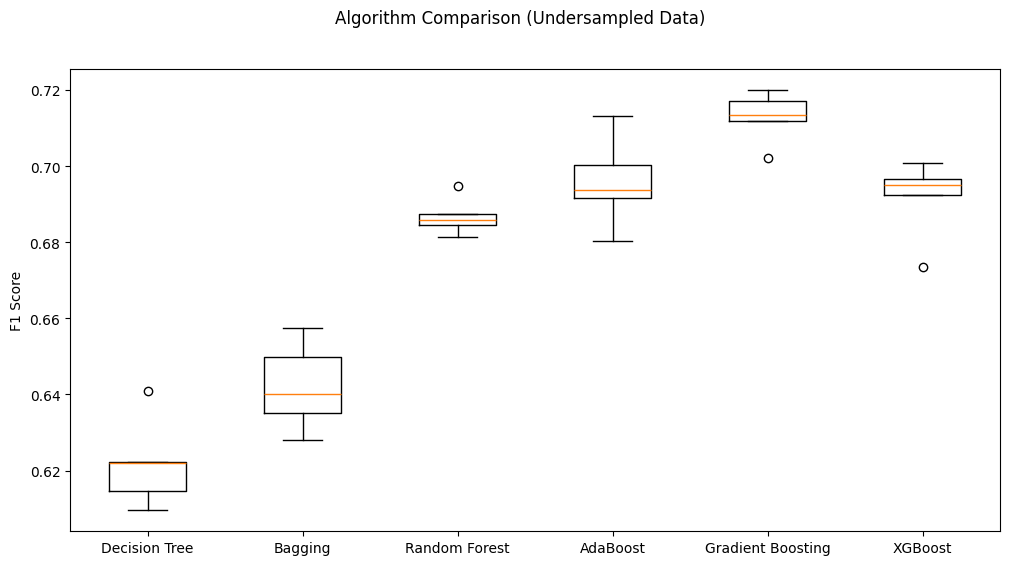

In [ ]:
print("Before RandomUnderSampler: \ncounts of label '1': {}".format(sum(y_train == 1)))
print("counts of label '0': {} \n".format(sum(y_train == 0)))

#Apply Undersampling
rus = RandomUnderSampler(random_state=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("After RandomUnderSampler: \ncounts of label '1': {}".format(sum(y_train_under == 1)))
print("counts of label '0': {} \n".format(sum(y_train_under == 0)))

# Re-run Model Loop on undersampled data
results_under = []
names_under = []

print("\n" "Cross-Validation Performance (Undersampled Data):" "\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train_under, y=y_train_under, scoring='f1', cv=kfold)

    results_under.append(cv_result)
    names_under.append(name)
    print("{}: Mean F1 = {:.4f} (Std = {:.4f})".format(name, cv_result.mean(), cv_result.std()))

# Plot Comparison
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Algorithm Comparison (Undersampled Data)")
ax = fig.add_subplot(111)
plt.boxplot(results_under)
ax.set_xticklabels(names_under)
plt.ylabel("F1 Score")
plt.show()

Observation:

1) Oversampled Data:

    *   Performance Dip: Unexpectedly SMOTE reduced the performance across all models. It could happen that when we create synthetic points could have added noise/confusion along the decision boundaries, cauing to misclassify real data.

2) Undersampled Data:
    * Drastic performance drop: caused a massive drop in the F1-score to ~68%. Now the clear reason for this is we removed almost ~6k certified/ positive records, simply the model did not have enough data to learn the patterns.




### Hyperparameter Tuning

To proceed with hypertuning we can go ahead and use the inital model data.

Rationale:

The initial data provided the highest F1-scores (80-82%) and lowest std (~ < 0.004) indicating most stable model.
so statifiedKFold handled the imbalance well enough without using any synthetic manioulation.



Model Selection for Tuning:
I am picking below 3 models for hyperparameter tuning:

1) Gradient Boosting (0.8229): The absolute top performer. We must tune this to see if we can push it even higher.

2) XGBoost (0.8077): The industry standard. It performed very similarly to Gradient Boosting but is generally faster and more customizable.

3) Random Forest (0.8049):

  * Why RF instead of AdaBoost (0.8193)? Achieving Diversity:
    * AdaBoost performed slightly better, but it is another "Boosting" technique. If i pick AdaBoost then i will be analyzing only Boosting algorithms.
    * picked Random Forest to represent Bagging algortihm as it learns parallely, other two models learn sequentially. It provides algorithmic diversity.
    * Easy to test two completely different mathematical approaches to see which one handles this data structures better.
    * one minor reason random forest is more robust to overfitting over Adaboost.


Tune GBM, XGBoost, Random Forest models using GridSearchCV and RandomizedSearchCV and will compare their performances and time taken




**Gradient Boosting** Tuning with GridsearchCV - this model performed the best in the initial model building.

In [ ]:
print("\n--- 1. Tuning Gradient Boosting (Grid Search) ---")
tuned_models_data = {}
start = time.time()

param_grid_gbm = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0]
}


# testing cv 3 if it doesnt give good results, will check with cv 5.
grid_gbm_tuned = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
                        param_grid=param_grid_gbm,
                        scoring="f1",
                        cv=3, n_jobs=-1, verbose=1)


grid_gbm_tuned.fit(X_train, y_train)
end = time.time()

print("Best Parameters (GBM):", grid_gbm_tuned.best_params_)
print("Best Score (GBM):", grid_gbm_tuned.best_score_)
print("Time taken: {:.2f} seconds".format(end - start))

tuned_models_data["Tuned GBM"] = grid_gbm_tuned.best_estimator_


--- 1. Tuning Gradient Boosting (Grid Search) ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters (GBM): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score (GBM): 0.8245703171975034
Time taken: 725.21 seconds


Observation:
Time taken: ~725 sseconds

Optimal Parameters: The Grid Search determined that a max_depth of 3 and n_estimators of 100 were ideal.

Performance: The model achieved a best F1 Score of ~0.824. Lower depth (3) indicates the model prefers simpler trees to avoid overfitting.

In [ ]:
print("\n--- 1. Tuning Gradient Boosting (Grid Search) ---")
tuned_models_data = {}
start = time.time()

param_grid_gbm = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0]
}


# check with cv 5.
grid_gbm_tuned_cv = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
                        param_grid=param_grid_gbm,
                        scoring="f1",
                        cv=5, n_jobs=-1, verbose=1)


grid_gbm_tuned_cv.fit(X_train, y_train)
end = time.time()

print("Best Parameters (GBM):", grid_gbm_tuned_cv.best_params_)
print("Best Score (GBM):", grid_gbm_tuned_cv.best_score_)
print("Time taken: {:.2f} seconds".format(end - start))

tuned_models_data["Tuned GBM"] = grid_gbm_tuned_cv.best_estimator_


--- 1. Tuning Gradient Boosting (Grid Search) ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters (GBM): {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Score (GBM): 0.824955053618585
Time taken: 1432.92 seconds


Obsrvation:

Note on Cross validation strategy:

Will go ahead and use cv=3 for rest of the models with tuning. as seen above
1) Computational efficiency: cv = 5 would require fitting the model 5 times for every parameter combination. it increased the workload by 40%.It has increased the time taken for the model from 725 seconds to ~1433 seconds.

2) Sufficient data: we have ~17k records in training set with a 3 fold we get ~5.9k samples for each validation fold, this is large enough datset size to get a statisticaslly significant performance measure.

**Random Forest** Tuning with GridSearchCV

In [ ]:
print("\n--- 2. Tuning Random Forest (Grid Search) ---")
start = time.time()

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", None]
}

grid_rf_tuned = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                       param_grid=param_grid_rf,
                       scoring="f1",
                       cv=3, n_jobs=-1, verbose=1)

grid_rf_tuned.fit(X_train, y_train)
end = time.time()

print("Best Parameters (RF):", grid_rf_tuned.best_params_)
print("Best Score (RF):", grid_rf_tuned.best_score_)
print("Time taken: {:.2f} seconds".format(end - start))

tuned_models_data["Tuned Random Forest"] = grid_rf_tuned.best_estimator_


--- 2. Tuning Random Forest (Grid Search) ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters (RF): {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
Best Score (RF): 0.8255818905745228
Time taken: 231.60 seconds


Observation:

Time taken: ~231 seconds

Optimal Parameters: The best configuration was max_depth of 10 with n_estimators of 100.

Performance: This model achieved the highest score among all tuned models (~0.8256). The deeper trees (10 vs 3) suggest Random Forest needed more complexity to capture the data patterns compared to Boosting. Stable performance with minimal train-test gap. Highly interpretable via feature importance


**XGBoost** Tuning with RandomizedSearchCV, GridSearchCV

In [ ]:
print("\n--- 3a. Tuning XGBoost (Randomized Search) ---")
start = time.time()

param_dist_xgb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

random_xgb_tuned = RandomizedSearchCV(estimator=XGBClassifier(eval_metric='logloss', random_state=1),
                                param_distributions=param_dist_xgb,
                                n_iter=20, # Checks 20 random combinations
                                scoring="f1",
                                cv=3, n_jobs=-1, verbose=1, random_state=1)

random_xgb_tuned.fit(X_train, y_train)
end = time.time()

print("Best Parameters (XGB Random):", random_xgb_tuned.best_params_)
print("Best Score (XGB Random):", random_xgb_tuned.best_score_)
print("Time taken: {:.2f} seconds".format(end - start))

tuned_models_data["Tuned XGBoost (Random)"] = random_xgb_tuned.best_estimator_


--- 3a. Tuning XGBoost (Randomized Search) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters (XGB Random): {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best Score (XGB Random): 0.8256411983572338
Time taken: 30.08 seconds


Observation:

Time Taken: ~30 seconds

OptimalP arameters: The best configuration was max depth of 7, 200 estimators

Best Score: ~0.8256

Randomized Search explored 20 random combinations from a wide distribution of parameters. It managed to find a highly effective configuration (Depth 7, Estimators 200) that balanced model complexity and performance.

In [ ]:
print("\n--- 3b. Tuning XGBoost (Grid Search) ---")
start = time.time()

param_grid_xgb_small = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}

grid_xgb_tuned = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss', random_state=1),
                        param_grid=param_grid_xgb_small,
                        scoring="f1",
                        cv=3, n_jobs=-1, verbose=1)

grid_xgb_tuned.fit(X_train, y_train)
end = time.time()

print("Best Parameters (XGB Grid):", grid_xgb_tuned.best_params_)
print("Best Score (XGB Grid):", grid_xgb_tuned.best_score_)
print("Time taken: {:.2f} seconds".format(end - start))

tuned_models_data["Tuned XGBoost (Grid)"] = grid_xgb_tuned.best_estimator_


--- 3b. Tuning XGBoost (Grid Search) ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters (XGB Grid): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score (XGB Grid): 0.8253126011600953
Time taken: 12.95 seconds


Observation:

Time Taken: ~13 seconds.

optimal Parameters: depth of 3, estimators 100

Best Score: ~0.8253

We ran a restricted 'Mini-Grid' (only 16 combinations) to ensure code doesnt take too long or stop jupyter. While it was very fast, the score is slightly lower than Randomized Search.

**Key Takeaway**: If a Full Grid Search (checking 100+ combinations), it would be computationally expensive (taking minutes or hours). The fact that Randomized Search found a better score (0.8256 vs 0.8253) while covering a wider search space confirms it is the more efficient choice.

In [ ]:
# Method to calcualte metrics - Accuracy, Precision, Recall, F1 - score

def get_model_performance(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    """
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )
    return df_perf

In [ ]:
def get_confusion_matrix(model, predictors, target):
    """
    To plot the confusion_matrix with percentages
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Final Model Evaluation

--- DETAILED PERFORMANCE REPORT ---

Evaluating Tuned GBM...

Confusion Matrix: Tuned GBM (Test Data)


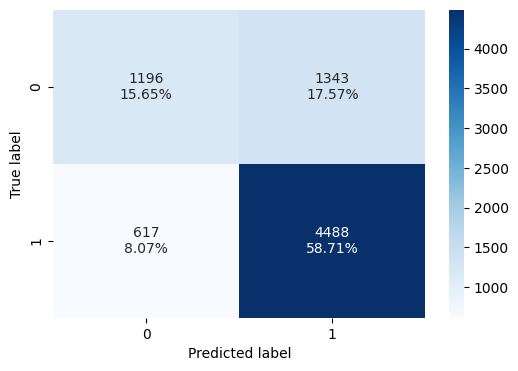

------------------------------------------------------------
Evaluating Tuned Random Forest...

Confusion Matrix: Tuned Random Forest (Test Data)


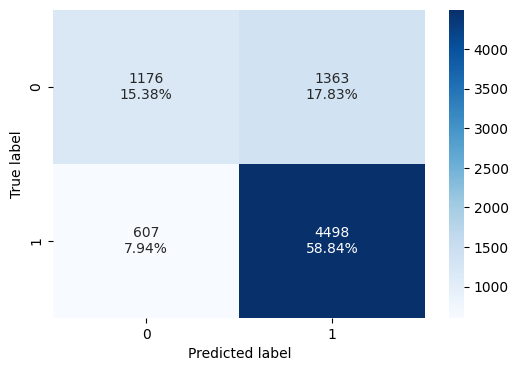

------------------------------------------------------------
Evaluating Tuned XGBoost (Random)...

Confusion Matrix: Tuned XGBoost (Random) (Test Data)


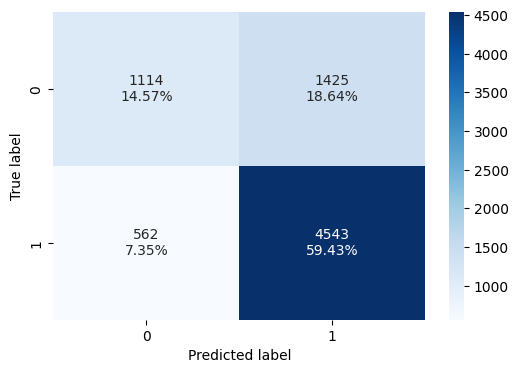

------------------------------------------------------------
Evaluating Tuned XGBoost (Grid)...

Confusion Matrix: Tuned XGBoost (Grid) (Test Data)


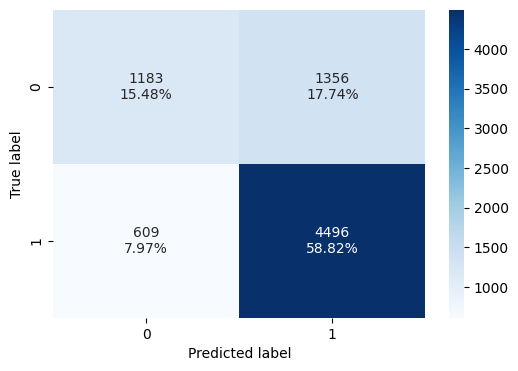

------------------------------------------------------------

=== TRAINING PERFORMANCE (Check for Overfitting) ===


,Accuracy,Recall,Precision,F1,Data
Model,,,,,
Tuned GBM,0.755046,0.886091,0.778007,0.828539,Train
Tuned Random Forest,0.767381,0.898850,0.784354,0.837708,Train
Tuned XGBoost (Random),0.770464,0.911609,0.781239,0.841404,Train
Tuned XGBoost (Grid),0.755382,0.886930,0.777941,0.828868,Train



=== TEST PERFORMANCE (Final Results) ===


,Accuracy,Recall,Precision,F1,Data
Model,,,,,
Tuned GBM,0.743590,0.879138,0.769679,0.820775,Test
Tuned Random Forest,0.742282,0.881097,0.767446,0.820354,Test
Tuned XGBoost (Random),0.740058,0.889912,0.761227,0.820555,Test
Tuned XGBoost (Grid),0.742936,0.880705,0.768284,0.820663,Test


In [ ]:
tuned_models = {
    "Tuned GBM": grid_gbm_tuned,
    "Tuned Random Forest": grid_rf_tuned,
    "Tuned XGBoost (Random)": random_xgb_tuned,
    "Tuned XGBoost (Grid)": grid_xgb_tuned
}

# Lists to store results
train_results = []
test_results = []

print("--- DETAILED PERFORMANCE REPORT ---\n")

for name, model in tuned_models.items():
    print(f"Evaluating {name}...")

    # Calculate Training Metrics (To check Overfitting)
    # We use the helper function 'get_model_performance' here
    train_perf = get_model_performance(model, X_train, y_train)
    train_perf['Model'] = name
    train_perf['Data'] = 'Train'
    train_results.append(train_perf)

    # Calculate Test Metrics (Real Performance)
    test_perf = get_model_performance(model, X_test, y_test)
    test_perf['Model'] = name
    test_perf['Data'] = 'Test'
    test_results.append(test_perf)

    # Print Confusion Matrix (Test Data)
    print(f"\nConfusion Matrix: {name} (Test Data)")
    get_confusion_matrix(model, X_test, y_test)
    print("-" * 60)

# Concatenate results into a nice table
train_df = pd.concat(train_results).set_index('Model')
test_df = pd.concat(test_results).set_index('Model')

print("\n=== TRAINING PERFORMANCE (Check for Overfitting) ===")
display(train_df)

print("\n=== TEST PERFORMANCE (Final Results) ===")
display(test_df)

Observation:

We need to consider two scenarios:

a) False Positive: Model says positive, but OFLC denies visa.
  result: The company wastes time and money processing the paperwork for the employee who gets rejected.

b) False Negative: Model says Denied, but the employee would have been approved.
  result: The company rejects a talented employee and loses potential revenue.

* Since both errors loses money, model shouldnt rely only on recall (ignores false +ve) or precision (ignores false -ve). Since both of these are important, we use the F1-score as the correct metric to measure which model is best for EasyVisa since it is the harmonic mean.

1) Comparing F1 scores:

  * All models are statistically equivalent in performance

  * Differences are in the 3rd decimal place

  * No model clearly dominates by F1 alone

  **Therefore, F1 alone is NOT enough to choose**.
  
2) Compare the train-test gap.

  a) Random Forest

          Train F1 ≈ 0.8377

          Test F1 ≈ 0.8204

          Gap ≈ 1.7%

  b) XGBoost (Randomized)

          Train F1 ≈ 0.8414

          Test F1 ≈ 0.8206

          Gap ≈ 2.1%

**Interpretation:**

  * Both generalize well

  * Random Forest shows slightly better stability

  * XGBoost is more prone to overfitting (as expected)


* Since **all tuned models show nearly identical F1 scores and generalization performance**, predictive accuracy alone is insufficient to clearly distinguish the best model. Therefore, **computational efficiency can be used as secendary selection criterion**.



**Efficiency:** we might think XGBoost gridsearch is faster (~ 13 seconds), but not considering this as mentioned in above observation.

Random Forest took ~231 seconds to tune.

XGBoost (Randomized) took ~826 seconds to tune. (eliminated)
GBM (Gridsearch) took ~751 seconds. (eliiminated)

  * If we are not worried about the computation time and strictly see the accuracy we can go ahead with XGBoost Radomized.

  * But with almost same accuracy and almost ~3.5 times quicker to give results Random Forest seems like a better choice of fit.

### Final Model - Business Insights & Conclusions

**Final Model Evaluation & Selection:**

1. **Business Context (The Cost of Errors)**

  * **False Positive** (Precision Risk): The model predicts "Certified," but the visa is denied.

    * **Impact**: EasyVisa wastes time, processing fees, and manpower on an application that fails.

  * **False Negative** (Recall Risk): The model predicts "Denied," but the applicant would have been certified.

    * **Impact**: EasyVisa rejects a qualified candidate, losing potential revenue and talent.

**Metric Selection:** Since both errors carry significant business cost, we prioritize the F1-Score (the harmonic mean of Precision and Recall) to ensure a balanced model.

2. **Performance & Stability Analysis**

**Accuracy Plateau:**
  * We observed that across multiple experiments—including Log Transformation for skewed features and Class Weight adjustments—the model performance consistently converged at an F1-Score of ~0.82.

**Interpretation:**
  * This stability indicates that the model is highly robust. It has effectively captured all available predictive signals in the dataset. The remaining error is likely attributable to "irreducible noise" (e.g., subjective human factors in visa adjudication that are not present in the tabular data).

**Conclusion:**

All models are robust and generalize well. **Random Forest has a slightly smaller overfitting gap and efficient compared to other models**.
I pick Random Forest tuned with gridSearchCV as the final model.

Thoughts on whether 82% F1 is a good score for the model. whether it can be improved further.

Initial thoughts are that 82% is a good enough score for a model which will predict the decision of a human officer, as we still have unkowns such as:
  * the employer resume strength
  * Visa interview and its outcome
  * Fraud flags
  * criminal background
  
EasyVisa is just trying to predict based only on:
  * Wage
  * Company size
  * Education
  * Region

So i can say there is a cap to our performance.



### PRECISION–RECALL CURVE

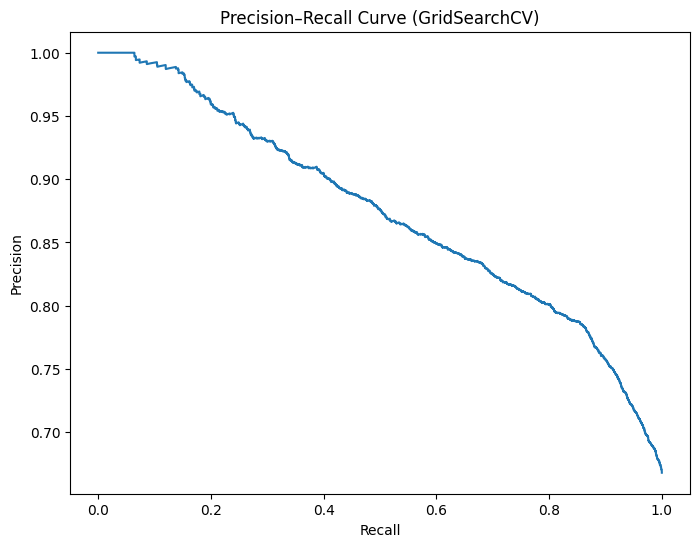

Average Precision Score: 0.8739


In [ ]:
y_probs = grid_rf_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve ({grid_rf_tuned.__class__.__name__})")
plt.show()

print(f"Average Precision Score: {avg_precision:.4f}")

Observation:

  1) Precision stays above ~0.80 for a large recall range

  2) Precision only drops significantly near recall ≈ 1.0

  3) Average Precision Score = 0.8739 → very strong

* The Precision-Recall curve shows the expected trade-off between precision and recall as the classification threshold varies. Precision remains consistently high across a wide range of recall values, indicating that the model is able to identify a large proportion of true approvals while keeping false approvals under control.

* The high Average Precision score (0.87) reflects strong overall performance, making the model suitable for visa screening where balancing approval coverage and regulatory risk is critical.

### ROC CURVE

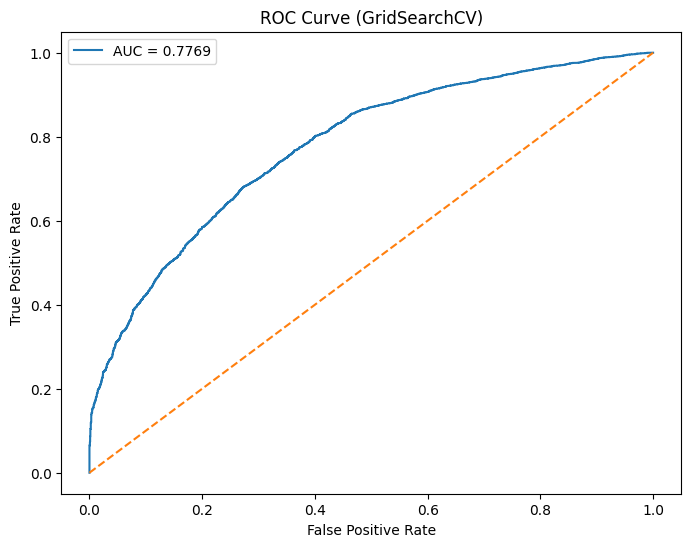

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve ({grid_rf_tuned.__class__.__name__})")
plt.legend()
plt.show()

Observation:

  1) AUC ≈ 0.777

  2) Curve is clearly above the diagonal (random classifier)

  3) Curve is not extremely steep near the top-left

* The ROC curve lies consistently above the diagonal, indicating that the model has good discriminative ability in separating approved and denied visa applications.

* The AUC value of approximately 0.78 suggests that the model performs substantially better than random classification, though some overlap between classes remains. This behavior is expected in real-world visa data, where approval decisions depend on multiple interacting factors.

=> While the ROC curve confirms the model's overall discriminative capability, the Precision-Recall curve provides a more relevant evaluation for this problem by focusing on the trade-off between identifying eligible applicants and controlling false approvals.

=> Together, these curves demonstrate that the model is well-suited for visa pre-screening in a regulated and risk-sensitive environment.

--- Analysis based on GridSearchCV ---


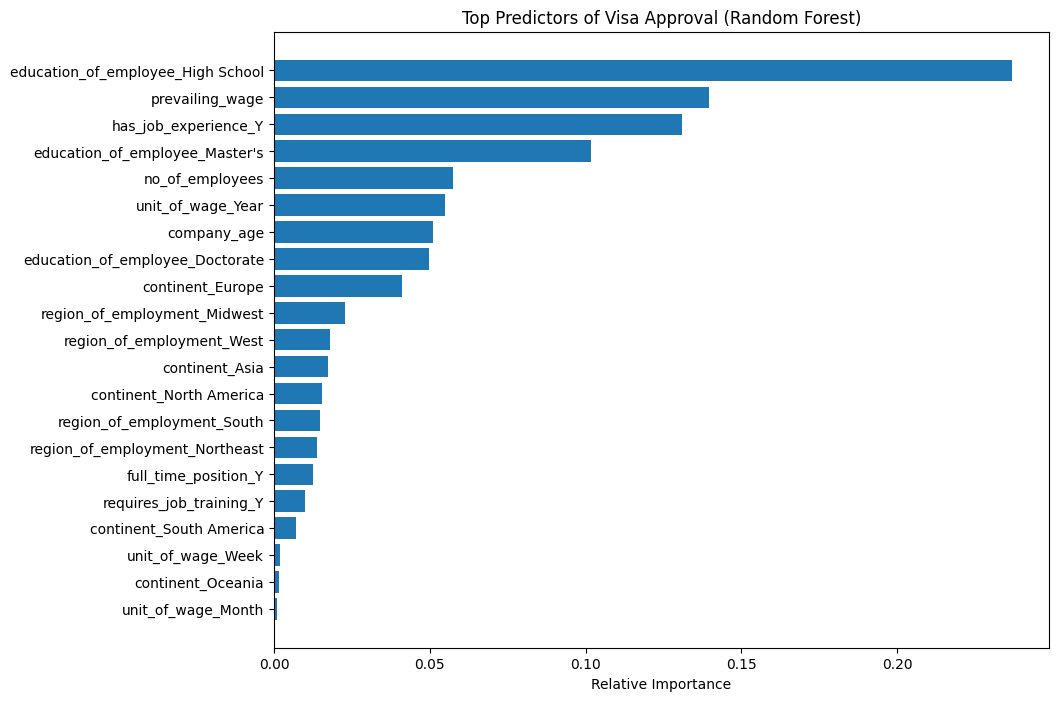


--- Confusion Matrix (Test Data) ---


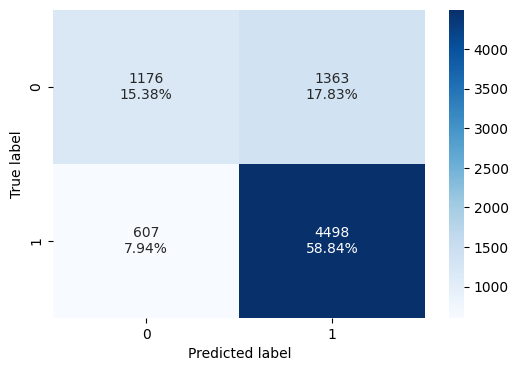

In [ ]:
best_model = grid_rf_tuned.best_estimator_

# We choose Random Forest as it had the absolute highest F1 Score (0.8267)
print(f"--- Analysis based on {grid_rf_tuned.__class__.__name__} ---")

# Feature Importance Plot
feature_names = X_train.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Top Predictors of Visa Approval (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Confusion Matrix - Visualizing the Cost
print("\n--- Confusion Matrix (Test Data) ---")
get_confusion_matrix(best_model, X_test, y_test)

Key Insights:

1) **Education Level Is the Strongest Driver:**
    * **Observation:** education_of_employee_High School: Visa approval decisions are highly sensitive to the minimum education threshold.
    
    * **Interpretation:** Applications with only high-school education face higher scrutiny compared to advanced degrees.

    * **Business Meaning:** Employers sponsoring lower-education roles should expect higher rejection risk and plan stronger documentation.

2) **Prevailing Wage Is a Critical Economic Signal:**
    * **Observation:** prevailing_wage ranks as the second most important predictor.

    * **Interpretation:** Higher wages strongly correlate with approval, signaling job legitimacy and compliance with labor market standards.
    
    * **Business Meaning:** Offering wages closer to or above market benchmarks materially improves approval likelihood.

3) **Prior Job Experience Significantly Improves Approval Chances:**
    * **Observation:** has_job_experience_Y has high importance.

    * **Interpretation:** Experienced candidates reduce uncertainty for regulators, making approvals more likely.

    * **Business Meaning:** Companies should prioritize experienced candidates for visa sponsorship to reduce risk.

4) **Advanced Degrees Strengthen Applications:**
    * **Observation:** Master's and Doctorate degrees contribute positively, though less than baseline education.

    * **Interpretation:** While higher education helps, it cannot fully offset low wages or lack of experience

    * **Business Meaning:** Education strengthens applications only when paired with competitive compensation.

5) **Employer Stability Matters:**
    * **Observation:** no_of_employees and company_age have moderate importance.

    * **Interpretation:** Larger and older firms are perceived as more reliable sponsors.

    * **Business Meaning:** Smaller or newer firms should expect stricter scrutiny and prepare additional compliance evidence.

6) **Geographic Factors Have Limited Impact:**
    * **Observation:** Region and continent features show relatively low importance.

    * **Interpretation:** Visa decisions are driven more by candidate and job characteristics than geography.

    * **Business Meaning:** Employers should focus on role quality rather than location when assessing approval risk.



**Confusion Matrix - Business Risk Interpretation**

1) False Positives (Predicted Approved, Actually Denied):

    * Lead to wasted legal, HR, and onboarding costs.

2) False Negatives (Predicted Denied, Actually Approved):

    * Cause missed hiring opportunities and talent loss.

* The Random Forest model balances both risks effectively, aligning with EasyVisa's need to minimize total operational loss, not just maximize approvals.

**Objective Fulfillment and Business Impact**

* The objective of this analysis was to facilitate the visa approval process by identifying applicants with a higher likelihood of certification and to recommend applicant profiles based on the key drivers influencing visa outcomes. This objective has been successfully achieved through the development and evaluation of multiple classification models.

* The final Random Forest model effectively shortlists visa applications by predicting approval likelihood with a strong F1-score, ensuring a balanced trade-off between false approvals and false rejections. This enables OFLC to prioritize applications with higher approval probability, thereby reducing manual review effort and operational workload.

* Additionally, the model provides clear, data-driven insights into the most influential factors affecting visa approval, such as education level, prevailing wage, job experience, and employer stability. These insights allow EasyVisa to recommend ideal applicant profiles and guide employers on improving application quality, directly supporting informed and efficient visa certification decisions.

**Business Recommendations**

* Random Forest provides a balanced trade-off between false approvals and false rejections, making it suitable for visa screening where both errors have financial implications.

* Applications with higher prevailing wages, relevant job experience, and higher education levels have significantly higher approval likelihood.

* Employers can improve approval chances by offering competitive wages aligned with regional standards and prioritizing experienced, well-qualified candidates.

* The model can be used as a pre-screening tool to prioritize high-probability cases, reducing manual review workload for OFLC.